In [25]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

vectorizer  = TfidfVectorizer()
stopwords = set(stopwords.words('english'))


In [2]:
dataset = pd.read_csv("IMDB-Dataset.csv")

In [3]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [41]:
positive_review = dataset[dataset['sentiment'] == "positive"]['review']
negative_review = dataset[dataset['sentiment'] == "negative"]['review']

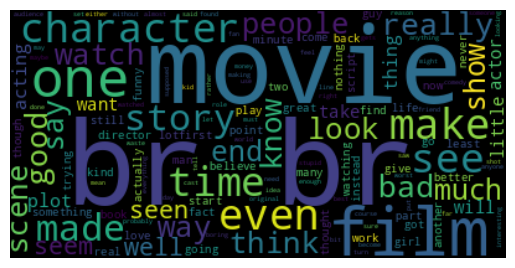

In [42]:

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(" ".join(negative_review))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [4]:
# Preprocessing

#1. Duplicates
print(f"Dataset size : {dataset.shape}")
print(f"Total duplicate data: {dataset.duplicated().sum()}")

dataset.drop_duplicates(keep='first', inplace=True)

print(f"Dataset size after duplicate removal: {dataset.shape}")

Dataset size : (50000, 2)
Total duplicate data: 418
Dataset size after duplicate removal: (49582, 2)


In [5]:
feature = dataset['review']
target = dataset['sentiment']

In [6]:
#2. Target encoding
label_encode = {
    "negative":0,
    "positive":1
}
target = target.replace(label_encode).to_numpy()

/tmp/ipykernel_36844/1739882405.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target = target.replace(label_encode).to_numpy()


In [15]:
# Text Processing

# Lemmatization
lemmatizer = WordNetLemmatizer()

def text_preprocessing(text):
    #1. lowercase
    text = text.lower()
        
    #3. remove urls, html, emoji
    text = re.sub(r"http\S+","", text) # url tag
    text = re.sub(r'<.*?>', "", text) # html tag
    text = re.sub(r"^a-zA-Z¿]+", " ", text) # emoji

    #2. remove puncuation and characters
    text = re.sub(r'[^\w\s]',' ', text)
    
    #4. remove stopwords
    text = [word for word in text.split() if word not in stopwords]
    text = " ".join(text)
    
    #5 : lemmatization
    text = lemmatizer.lemmatize(text)

    # #6 : Tokenization
    # tokens = text.split(" ")
    
    return text


In [16]:
feature_cleaned = feature.apply(text_preprocessing).to_numpy()

In [19]:
feature_cleaned[0]

'one reviewers mentioned watching 1 oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street ski

In [20]:
# split train test
X_train, X_test, y_train, y_test = train_test_split(feature_cleaned, target, test_size=0.2, stratify=target, shuffle=True, random_state=76)

In [23]:
# Vectorisation
## Using TF-IDF
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [26]:
# Applying Logistic Regression
logistic_reg = LogisticRegression(penalty='l2',max_iter=500,C=1, random_state=42, n_jobs=-1)

logistic_reg.fit(X_train, y_train)

logistic_reg.score(X_test, y_test)

LogisticRegression(C=1, max_iter=500, n_jobs=-1, random_state=42)

## Using BERT Embeddings

In [43]:
from transformers import BertTokenizer, BertModel

In [47]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/home/shailesh/Desktop/VritEducation/vritvenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [61]:
tokens = tokenizer(text= "The quick brown fox jumps over the lazy dog.", return_tensors='pt')

In [62]:
embeddings = model(**tokens).last_hidden_state

In [63]:
embeddings.shape

torch.Size([1, 12, 768])

In [68]:
tokens = [tokenizer(each, return_tensors='pt') for each in feature_cleaned]

Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


In [72]:
model(**tokens[0]).last_hidden_state.shape

torch.Size([1, 182, 768])